<a href="https://colab.research.google.com/github/emartinmorgan/OPPlogfileanalysis/blob/main/logpregnorm_sankey.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Sankey Tutorial](https://towardsdatascience.com/visualizing-in-app-user-journey-using-sankey-diagrams-in-python-8373a7bb2d22)

In [ ]:
# Load data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install chart_studio
import pandas as pd
import numpy as np
# import chart_studio.plotly as cspy
import plotly.graph_objects as go
import matplotlib.pyplot as plt

# import chart_studio.plotly as py
import plotly.graph_objects as go

import plotly.express as px
# import chart_studio.plotly as py
import plotly

import seaborn as se
from google.colab import files
print("hello world")

hello world


In [ ]:
norm = pd.read_csv("/content/drive/MyDrive/OSU - BMI/Fareed Lab/Thesis/Data_Final/Sankey/sank_norm_fin.csv")
norm

,pat_epi,clus_norm_id,clus_norm,tri
0,1.1,1.0,Average Users,1
1,3.1,2.0,Intense Digital Engagers,1
2,5.1,3.0,Average Users,1
3,8.1,4.0,Resulters,1
4,13.1,5.0,Average Users,1
...,...,...,...,...
24927,17404.1,6226.0,Average Users,4
24928,17405.1,6227.0,Average Users,4
24929,17406.1,6228.0,Prepared Engagers,4
24930,17407.1,6229.0,Average Users,4


([0, 1, 2, 3, 4, 5], <a list of 6 Text major ticklabel objects>)

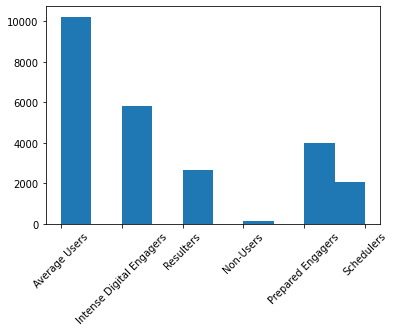

In [ ]:
plt.hist(norm.clus_norm,bins=10)
plt.xticks(rotation = 45)

In [ ]:
# Based on the tri, we can compute the rank of each cluster at the pat_epi level:

# a) Sort ascendingly per pat_epi and tri

norm.sort_values(['pat_epi', 'tri'],
                 ascending=[True, True], inplace=True)
norm.head()

,pat_epi,clus_norm_id,clus_norm,tri
0,1.1,1.0,Average Users,1
6233,1.1,1.0,Intense Digital Engagers,2
12466,1.1,1.0,Average Users,3
18699,1.1,1.0,Average Users,4
1,3.1,2.0,Intense Digital Engagers,1


In [ ]:
norm=norm[norm.tri!=4]

In [ ]:
# b) Define a ranking function based on tri, using the method = 'first' param to ensure no clusters have the same rank

# def rank(x): return x['tri'].rank(method='first').astype(int)

# c) Group by user_id 
grouped = norm.groupby('pat_epi')

# d) Apply the ranking function to the all DF into a new "rank_clus" column
# norm["rank_clus"] = grouped.apply(rank).reset_index(0, drop=True)

# e) The shift function allows to access the next row's data. Here, we'll want the cluster name
def get_next_clus(x): return x['clus_norm'].shift(-1)

# f) Apply the function into a new "next_clus" column
norm["next_clus"] = grouped.apply(
     lambda x: get_next_clus(x)).reset_index(0, drop=True)

# g) Regroup by user_id 
grouped = norm.groupby('pat_epi')
norm.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,pat_epi,clus_norm_id,clus_norm,tri,next_clus
0,1.1,1.0,Average Users,1,Intense Digital Engagers
6233,1.1,1.0,Intense Digital Engagers,2,Average Users
12466,1.1,1.0,Average Users,3,NaN
1,3.1,2.0,Intense Digital Engagers,1,Intense Digital Engagers
6234,3.1,2.0,Intense Digital Engagers,2,Schedulers


We attribute a unique color to each event, and name this dict nodes_dict.

In [ ]:
# Working on the nodes_dict

norm_clus = list(norm.clus_norm.unique())

# Create a set of colors that you'd like to use in your plot.
palette = ['50BE97', 'E4655C', 'FBEEAC', '3E5066',
           'BFD6DE', 'FCC865', '353A3E', 'E6E6E6']
#  Here, I passed the colors as HEX, but we need to pass it as RGB. This loop will convert from HEX to RGB:
for i, col in enumerate(palette):
    palette[i] = tuple(int(col[i:i+2], 16) for i in (0, 2, 4))

# Append a Seaborn complementary palette to your palette in case you did not provide enough colors to style every event
# complementary_palette = se.color_palette("deep", len(all_events) - len(palette))
# if len(complementary_palette) > 0:
#     palette.extend(complementary_palette)

output = dict()
output.update({'nodes_dict': dict()})

i = 0
for tri in norm.tri.unique(): # For each tri of clus...
    # Create a new key equal to the tri...
    output['nodes_dict'].update(
        {tri: dict()}
    )
    
    # Look at all the events that were done at this step of the funnel...
    norm_clus_at_this_tri = norm[norm.tri ==
                                   tri].clus_norm.unique()
    
    # Read the colors for these events and store them in a list...
    tri_palette = []
    for clus in norm_clus_at_this_tri:
        tri_palette.append(palette[list(norm_clus).index(clus)])
    
    # Keep trace of the events' names, colors and indices.
    output['nodes_dict'][tri].update(
        {
            'sources': list(norm_clus_at_this_tri),
            'color': tri_palette,
            'sources_index': list(range(i, i+len(norm_clus_at_this_tri)))
        }
    )
    # Finally, increment by the length of this rank's available clus to make sure next indices will not be chosen from existing ones
    i += len(output['nodes_dict'][tri]['sources_index'])

In [ ]:
norm_clus_at_this_tri

array(['Average Users', 'Schedulers', 'Intense Digital Engagers',
       'Resulters', 'Non-Users'], dtype=object)

In [ ]:
# Working on the links_dict

output.update({'links_dict': dict()})

# Group the DataFrame by pat_epi and tri
grouped = norm.groupby(['pat_epi', 'tri'])

# Define a function to read the souces, targets, values clus_norm to next_clus:
def update_source_target(user):
    try:
        # user.name[0] is the user's pat_epi; user.name[1] is the tri
        # 1st we retrieve the source and target's indices from nodes_dict
        source_index = output['nodes_dict'][user.name[1]]['sources_index'][output['nodes_dict']
                                                                           [user.name[1]]['sources'].index(user['clus_norm'].values[0])]
        target_index = output['nodes_dict'][user.name[1] + 1]['sources_index'][output['nodes_dict']
                                                                               [user.name[1] + 1]['sources'].index(user['next_clus'].values[0])]

         # If this source is already in links_dict...
        if source_index in output['links_dict']:
            # ...and if this target is already associated to this source...
            if target_index in output['links_dict'][source_index]:
                # ...then we increment the count of users with this source/target pair by 1
                output['links_dict'][source_index][target_index]['unique_users'] += 1
            # ...but if the target is not already associated to this source...
            else:
                # ...we create a new key for this target, for this source, and initiate it with 1 user and the time from source to target
                output['links_dict'][source_index].update({target_index:
                                                           dict(
                                                               {'unique_users': 1}
                                                            )
                                                           })
        # ...but if this source isn't already available in the links_dict, we create its key and the key of this source's target, and we initiate it with 1 user and the time from source to target
        else:
            output['links_dict'].update({source_index: dict({target_index: dict(
                {'unique_users': 1})})})
    except Exception as e:
        pass

# Apply the function to your grouped Pandas object:
grouped.apply(lambda user: update_source_target(user)) 



""


In [ ]:
norm.head()

,pat_epi,clus_norm_id,clus_norm,tri,next_clus
0,1.1,1.0,Average Users,1,Intense Digital Engagers
6233,1.1,1.0,Intense Digital Engagers,2,Average Users
12466,1.1,1.0,Average Users,3,NaN
1,3.1,2.0,Intense Digital Engagers,1,Intense Digital Engagers
6234,3.1,2.0,Intense Digital Engagers,2,Schedulers


In [ ]:
norm.groupby(['clus_norm','tri']).count()

pat_epi  clus_norm_id  next_clus
clus_norm                tri                                  
Average Users            1       2847          2847       2847
                         2       2255          2255       2255
                         3       2047          2047          0
Intense Digital Engagers 1       1129          1129       1129
                         2       1860          1860       1860
                         3       1597          1597          0
Non-Users                1         57             0         57
                         2         17             0         17
                         3         42             0          0
Prepared Engagers        2       2101          2101       2101
Resulters                1       2200          2200       2200
                         3        463           463          0
Schedulers               3       2084          2084          0

In [ ]:
targets = []
sources = []
values = []

for source_key, source_value in output['links_dict'].items():
    for target_key, target_value in output['links_dict'][source_key].items():
        sources.append(source_key)
        targets.append(target_key)
        values.append(target_value['unique_users'])
        
labels = []
colors = []

for key, value in output['nodes_dict'].items():
    labels = labels + list(output['nodes_dict'][key]['sources']) 
    colors = colors + list(output['nodes_dict'][key]['color'])
for idx, color in enumerate(colors):
    colors[idx] = "rgb" + str(color) + ""


In [ ]:
cc=norm.groupby(['clus_norm','tri']).count()
cc=cc.reset_index()
cc.groupby(by='tri').sum()

,pat_epi,clus_norm_id,next_clus
tri,,,
1,6233,6176,6233
2,6233,6216,6233
3,6233,6191,0


In [ ]:
cc['tri'].sort_values()

0     1
3     1
6     1
10    1
1     2
4     2
7     2
9     2
2     3
5     3
8     3
11    3
12    3
Name: tri, dtype: int64

In [ ]:
labels

['Average Users',
 'Intense Digital Engagers',
 'Resulters',
 'Non-Users',
 'Intense Digital Engagers',
 'Prepared Engagers',
 'Average Users',
 'Non-Users',
 'Average Users',
 'Schedulers',
 'Intense Digital Engagers',
 'Resulters',
 'Non-Users']

In [ ]:
cc=norm.groupby(['clus_norm','tri']).count()
cc=cc.reset_index()
# cc
cc=cc.sort_values(['tri'])
x=cc[cc.tri==1]['pat_epi']/6233
x=np.append(x,cc[cc.tri==2]['pat_epi']/6233)
x=np.append(x,cc[cc.tri==3]['pat_epi']/6233)
cc['perc']=(np.round(x*100)).astype(int)

cc['aa']=' ('
cc['bb']='%)'
cc=cc.iloc[[0,1,3,2,5,7,4,6,8,12,9,11,10],:]#4,0,1,2,5,3,8,7,9,6,10,15,11,14,13,16,12,18,19,17,21,20],:]
a=np.char.array(cc['clus_norm'].values)
b=np.char.array(cc['tri'].values)
c=np.char.array(cc['pat_epi'].values)
d=np.char.array(cc['perc'].values)
e=np.char.array(cc['aa'].values)
f=np.char.array(cc['bb'].values)
labels=(a + b' : ' + c + e + d + f).astype(str)
# cc['clus_all'].astype('str')+cc['tri'].astype('str')+cc['pat_epi'].astype('str')
# np.array(cc[['clus_all','tri']]).to_list()

In [ ]:
cc.reset_index()

,index,clus_norm,tri,pat_epi,clus_norm_id,next_clus,perc,aa,bb
0,0,Average Users,1,2847,2847,2847,46,(,%)
1,3,Intense Digital Engagers,1,1129,1129,1129,18,(,%)
2,10,Resulters,1,2200,2200,2200,35,(,%)
3,6,Non-Users,1,57,0,57,1,(,%)
4,4,Intense Digital Engagers,2,1860,1860,1860,30,(,%)
5,9,Prepared Engagers,2,2101,2101,2101,34,(,%)
6,1,Average Users,2,2255,2255,2255,36,(,%)
7,7,Non-Users,2,17,0,17,0,(,%)
8,2,Average Users,3,2047,2047,0,33,(,%)
9,12,Schedulers,3,2084,2084,0,33,(,%)


In [ ]:
# label = ["{} {}".format(node1_name, node1_val), "{} {}".format(node2_name, node2_val) ...]
fig = go.Figure(data=[go.Sankey(
    node=dict(
        thickness=20,  # default is 20
        line=dict(color="black", width=0.5),
        label=labels,
        color=colors
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        hovertemplate='%{value} unique pregnancy episodes went from %{source.label} to %{target.label}.<br />',
    ))])

fig.update_layout(autosize=True, title=dict(text="Movement of Clusters Among Normal Pregnancies", font_size=16), font=dict(size=12, family="Arial"), plot_bgcolor='white')
fig.show()